In [193]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import imutils
import matplotlib.pyplot as plt

def flatten_image(image):
    return np.array(image).flatten()

def flatten_images(images):
    return np.array([flatten_image(image) for image in images])

image_size = 32

In [194]:
def read_image(class_path, image_file):
    image_path = os.path.join(class_path, image_file)
    image =  cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

class_labels_list = []
images_list = []

data_directory = './dataset/'

#missing O
directories = ['@', "&", "#", "$", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z','0','1','2','3','4','5','6','7','8','9']

for class_label, class_name in enumerate(directories):
    class_path = os.path.join(data_directory, class_name)
    for image_file in os.listdir(class_path):
        if image_file.endswith('.jpg'):
            image = read_image(class_path, image_file)
            images_list.append(image)
            class_labels_list.append(class_label)

data_x = images_list
data_y = class_labels_list

X_train, X_test, y_train, y_test = train_test_split(data_x,data_y, 
                                                    test_size=0.25, 
                                                    random_state=13)

In [195]:
pca = PCA(n_components=50).fit(flatten_images(X_train))
X_train_pca = pca.transform(flatten_images(X_train))
X_test_pca = pca.transform(flatten_images(X_test))


In [196]:
pca_knn_classifier = KNeighborsClassifier(n_neighbors=5) 
pca_knn_classifier.fit(X_train_pca, y_train)
pca_knn_predictions = pca_knn_classifier.predict(X_test_pca)
pca_knn_accuracy = accuracy_score(y_test, pca_knn_predictions)

print("Random KNN PCA Classifier:")
print(f"Accuracy: {pca_knn_accuracy}")

random_sample = X_test[0]
print(pca.transform([flatten_image(random_sample)]))
random_sample_prediction = pca_knn_classifier.predict(pca.transform([flatten_image(random_sample)]))
print(f"Random Sample Prediction: {directories[random_sample_prediction[0]]}")

Random KNN PCA Classifier:
Accuracy: 0.881352187361909
[[-3.28211515e+02 -5.32633609e+02  2.29520375e+02 -8.44960459e+02
   6.81011588e+02  7.48673068e+02  7.61245996e+02 -1.10582802e+02
  -2.99536360e+02  1.72209691e+02 -3.24650737e+02 -1.06226978e+02
  -9.24326258e+01  6.68993099e+02 -3.70276935e+01 -4.08138458e+01
  -3.70619119e+02 -5.79995092e+02  2.96639054e+02 -1.34364177e+02
  -3.50951668e+01 -6.31016595e+01  1.22130377e+02  2.31709344e+00
  -7.69926684e+01 -1.95595123e+02 -3.41543057e+01  3.13484059e+02
  -3.71532050e+02 -1.45166488e+02 -1.70515333e+02 -8.49762041e+01
   2.97763409e+02 -6.92049735e-01  7.97243341e+01  1.15748496e+02
   1.44694181e+02  1.16171533e+02  8.73223784e+01 -6.62288957e+01
  -4.31873561e+01  9.26652737e+01 -9.99983442e+00  2.15731053e+02
   2.71922450e+01  2.51691683e+01 -2.22661959e+02 -7.18898130e+01
  -1.08418079e+00 -4.53102961e+01]]
Random Sample Prediction: R


In [197]:

def apply_sobel(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=5)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=5)

    gradient = [gx, gy]
    
    return gradient

x_train_sobel = [apply_sobel(image) for image in X_train]
x_test_sobel = [apply_sobel(image) for image in X_test]

In [198]:

x_test_sobel = flatten_images(x_test_sobel)
x_train_sobel = flatten_images(x_train_sobel)

sobel_knn_classifier = KNeighborsClassifier(n_neighbors=5)

sobel_knn_classifier.fit(x_train_sobel, y_train)

sobel_knn_predictions = sobel_knn_classifier.predict(x_test_sobel)

sobel_knn_accuracy = accuracy_score(y_test, sobel_knn_predictions)

print("Random KNN Direction Classifier:")
print(f"Accuracy: {sobel_knn_accuracy}")

Random KNN Direction Classifier:
Accuracy: 0.8331860362350861


In [199]:
X_train_combined = np.concatenate((X_train_pca, x_train_sobel), axis=1)
X_test_combined = np.concatenate((X_test_pca, x_test_sobel), axis=1)


merged_knn_classifier = KNeighborsClassifier(n_neighbors=5)

merged_knn_classifier.fit(X_train_combined, y_train)

merged_knn_predictions = merged_knn_classifier.predict(X_test_combined)

merged_knn_accuracy = accuracy_score(y_test, merged_knn_predictions)

print("Random KNN Combined Classifier:")
print(f"Accuracy: {merged_knn_accuracy}")


Random KNN Combined Classifier:
Accuracy: 0.8331860362350861


JF2HVM1FHEL


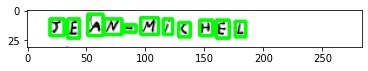

In [210]:
model = pca_knn_classifier

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(
        *sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse)
    )
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y : y + h, x : x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (image_size,image_size))
        thresh = pca.transform([flatten_image(thresh)])
        ypred = model.predict(thresh)
        [x] = ypred
        letters.append(x)
    return letters, image


def get_word(letter):
    word = ''
    for letter in letters:
        word += directories[letter]
    return word
    


letters, image = get_letters(
    "./dataset/words/validation/VALIDATION_0010.jpg"
)

word = get_word(letters)



print(word)
plt.imshow(image)